<a href="https://www.kaggle.com/code/jaymanvirk/leveraging-resnet-vgg-net-and-inceptionnet?scriptVersionId=146807098" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Plant Pathology: Leveraging pretrained neural networks for efficient image recognition with ResNet, VGG-Net and InceptionNet

**Jay Manvirk (Ivan Loginov)**<br/>University of Colorado, Boulder<br/>jay.manvirk@gmail.com

# Table of Contents

1. [Abstract](#chapter_1)
2. [Introduction](#chapter_2)
3. [Libraries and raw data](#chapter_3)
    - 3.1 [Libraries](#chapter_3_1)
    - 3.2 [Raw data](#chapter_3_2)
4. [Exploratory data analysis](#chapter_4)
    - 4.1 [Short datasets summary](#chapter_4_1)
    - 4.2 [Number of records per label](#chapter_4_2)
    - 4.3 [Images](#chapter_4_3)
5. [Data preprocessing](#chapter_5)
    - 5.1 [Upsampling](#chapter_5_1)
    - 5.2 [Data augmentation](#chapter_5_2)
    - 5.3 [Train-test split](#chapter_5_3)
    - 5.4 [Parallel preprocessing](#chapter_5_4)
6. [Model architectures](#chapter_6)
7. [Model results](#chapter_7)
    - 7.1 [ResNet](#chapter_7_1)
    - 7.2 [VGG-Net](#chapter_7_2)
    - 7.3 [InceptionNet](#chapter_7_3)
    - 7.4 [Table results comparison](#chapter_7_4)
8. [Submission results](#chapter_8)
9. [Conclusion](#chapter_9)
10. [References](#chapter_10)

# 1. Abstract <a class="anchor" id="chapter_1"></a>

In this study we explore the effectiveness of three pretrained convolutional neural network models, ResNet, VGG-Net and InceptionNet, in classifying plant pathologies from images. Our focus is on achieving high categorical accuracy scores for the four categories in the Plant Pathology dataset (Thapa, Ranjita et al., 2020): rust, scab, healthy, and multi-disease. The research investigates the use of these pretrained models to enhance training speed while aiming for superior classification performance. By leveraging these established architectures, we examine the feasibility of accelerating the training process while ensuring high accuracy in plant pathology classification.

# 2. Introduction <a class="anchor" id="chapter_2"></a>

The goal of this study is to conduct a comparative analysis of three pretrained convolutional neural network architectures:
1. ResNet
2. VGG-Net
3. InceptionNet

in the context of detecting plant pathologies from images. The primary objective is to achieve the highest possible categorical accuracy for accurate disease classification.

The dataset utilized in this research comprises:
* number of training images: 1821
* number of testing images: 1821
* image size: ~230 kB
* image shape: (2048, 1365, 3)

These images are categorized into four classes: rust, scab, healthy and multi-disease. The dataset has been sourced from Plant Pathology dataset (Thapa, Ranjita et al., 2020) and can be accessed using the link in the References section.

The following sections in the notebook will provide the necessary insights to arrive at the conclusion:

1. **Exploratory data analysis:**<br/>
The distribution of records per label, dataset size, and structure.
2. **Data preprocessing:**<br/>
Upsampling, data augmentation, and the train-test split procedure.
Parallel image processing methods for computational efficiency optimization.
3. **Model architectures:**<br/>
Three selected model architectures: ResNet (for deep network training), VGG (balancing simplicity and performance), and InceptionNet (capturing multi-scale features).
4. **Model results:**<br/>
An overview of each model's runtime, training and testing accuracy scores.
Suggestions for potential improvements to enhance the models' performance in plant pathology detection.

# 3. Libraries and raw data <a class="anchor" id="chapter_3"></a>

## 3.1 Libraries <a class="anchor" id="chapter_3_1"></a>

In [ ]:
# basics
import os
import time
import numpy as np

# EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Data preprocessing
import tensorflow as tf
import tensorflow_io as tfio
from sklearn.model_selection import train_test_split

# Deep learning
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# utilities
from tensorflow.keras.models import load_model

## 3.2 Raw Data <a class="anchor" id="chapter_3_2"></a>

In [2]:
# Print list of files and directories in folder
input_dir = '/kaggle/input/plant-pathology-2020-fgvc7'
files_dirs = [os.path.join(input_dir, x) for x in os.listdir(input_dir)]
files_dirs

['/kaggle/input/plant-pathology-2020-fgvc7/sample_submission.csv',
 '/kaggle/input/plant-pathology-2020-fgvc7/images',
 '/kaggle/input/plant-pathology-2020-fgvc7/train.csv',
 '/kaggle/input/plant-pathology-2020-fgvc7/test.csv']

In [3]:
# Set datasets and directory names
sample_data = pd.read_csv(files_dirs[0])
train_data = pd.read_csv(files_dirs[2])
test_data = pd.read_csv(files_dirs[3])
image_dir = files_dirs[1] + '/'

In [4]:
# Cleaning
del files_dirs

# 4. Exploratory data analysis <a class="anchor" id="chapter_4"></a>

## 4.1 Short datasets summary <a class="anchor" id="chapter_4_1"></a>

Both the training and testing tables have an 'image_id' column, which stores the image file names. In the next section, we'll use this column to get the images we need.

In [5]:
def print_short_summary(name, data):
    """
    Print data head, shape and info.
    
    Args:
        name (str): name of dataset
        data (dataframe): dataset in a pd.DataFrame format
    """
    print(name)
    print('\n1. Data head:')
    print(data.head())
    print('\n2. Data shape: {}'.format(data.shape))
    print('\n3. Data info:')
    data.info()
    
def print_number_files(dirpath):
    print('{}: {} files'.format(dirpath, len(os.listdir(dirpath))))

In [6]:
print_short_summary('Train data', train_data)

Train data

1. Data head:
  image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

2. Data shape: (1821, 5)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1821 non-null   object
 1   healthy            1821 non-null   int64 
 2   multiple_diseases  1821 non-null   int64 
 3   rust               1821 non-null   int64 
 4   scab               1821 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.3+ KB


In [7]:
print_short_summary('Test data', test_data)

Test data

1. Data head:
  image_id
0   Test_0
1   Test_1
2   Test_2
3   Test_3
4   Test_4

2. Data shape: (1821, 1)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  1821 non-null   object
dtypes: object(1)
memory usage: 14.4+ KB


In [8]:
print_short_summary('Sample data', sample_data)

Sample data

1. Data head:
  image_id  healthy  multiple_diseases  rust  scab
0   Test_0     0.25               0.25  0.25  0.25
1   Test_1     0.25               0.25  0.25  0.25
2   Test_2     0.25               0.25  0.25  0.25
3   Test_3     0.25               0.25  0.25  0.25
4   Test_4     0.25               0.25  0.25  0.25

2. Data shape: (1821, 5)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   image_id           1821 non-null   object 
 1   healthy            1821 non-null   float64
 2   multiple_diseases  1821 non-null   float64
 3   rust               1821 non-null   float64
 4   scab               1821 non-null   float64
dtypes: float64(4), object(1)
memory usage: 71.3+ KB


In [9]:
print_number_files(image_dir)

/kaggle/input/plant-pathology-2020-fgvc7/images/: 3642 files


In [10]:
# Cleaning
del print_short_summary, print_number_files

## 4.2 Number of records per label <a class="anchor" id="chapter_4_2"></a>

Our data is unevenly distributed among classes, which could affect our neural networks' learning. To fix this, we'll increase the number of samples in smaller classes to match the larger ones. With additional regularization this will help our networks learn better and make more accurate predictions, lowering the risk of overfitting.

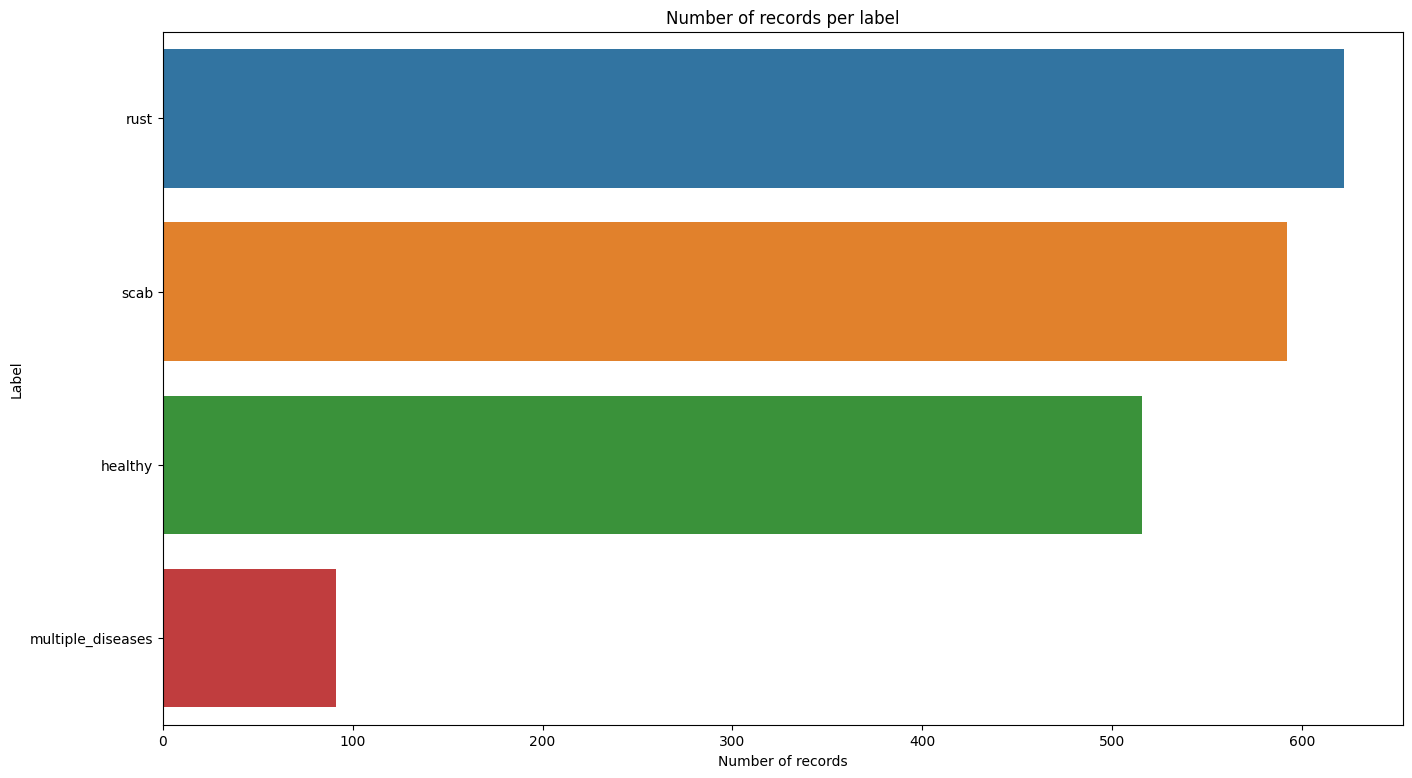

In [12]:
# Plot horizontal barplot of number of records per label
plt.figure(figsize=(16, 9))
tmp = train_data.iloc[:, 1:].sum().values
tmp = pd.DataFrame(tmp, train_data.columns[1:]).sort_values(by=[0], ascending = False)
sns.barplot(y = tmp.index, x = np.ravel(tmp.values), orient='h')
plt.xlabel('Number of records')
plt.ylabel('Label')
plt.title('Number of records per label')
plt.show()

## 4.3 Images <a class="anchor" id="chapter_4_3"></a>

In [13]:
def get_images_to_plot(file_names):
    """
    Return list of image objects.
    
    Args:
        file_names: list of filenames
    Returns:
        list: list of image objects
    """
    return [Image.open(f) for f in file_names]

def get_image_label(dirname, data, labels, n = 5):
    """
    Return dictionary with label-imagepath.
    
    Args:
        dirname: name of the directory
        data: dataset of file names
        labels: list of labels
        n (opt): number of images per label
    Returns:
        dict: dictionary with label-imagepath pairs
    """
    dict_img = {}
    for l in labels:
        indexes = data[l] == 1
        tmp = data[indexes][:n]
        tmp = dirname + tmp['image_id'] + '.jpg'
        tmp = tmp.values
        tmp = get_images_to_plot(tmp)
        dict_img[l] = tmp
        
    return dict_img

In [14]:
# Print original image size
img_path = image_dir + train_data['image_id'][0] + '.jpg'
img = Image.open(img_path)
print('Original image size: {}'.format(img.size))

Original image size: (2048, 1365)


In [15]:
# Get 5 filenames per label
data = get_image_label(image_dir, train_data, tmp.index)

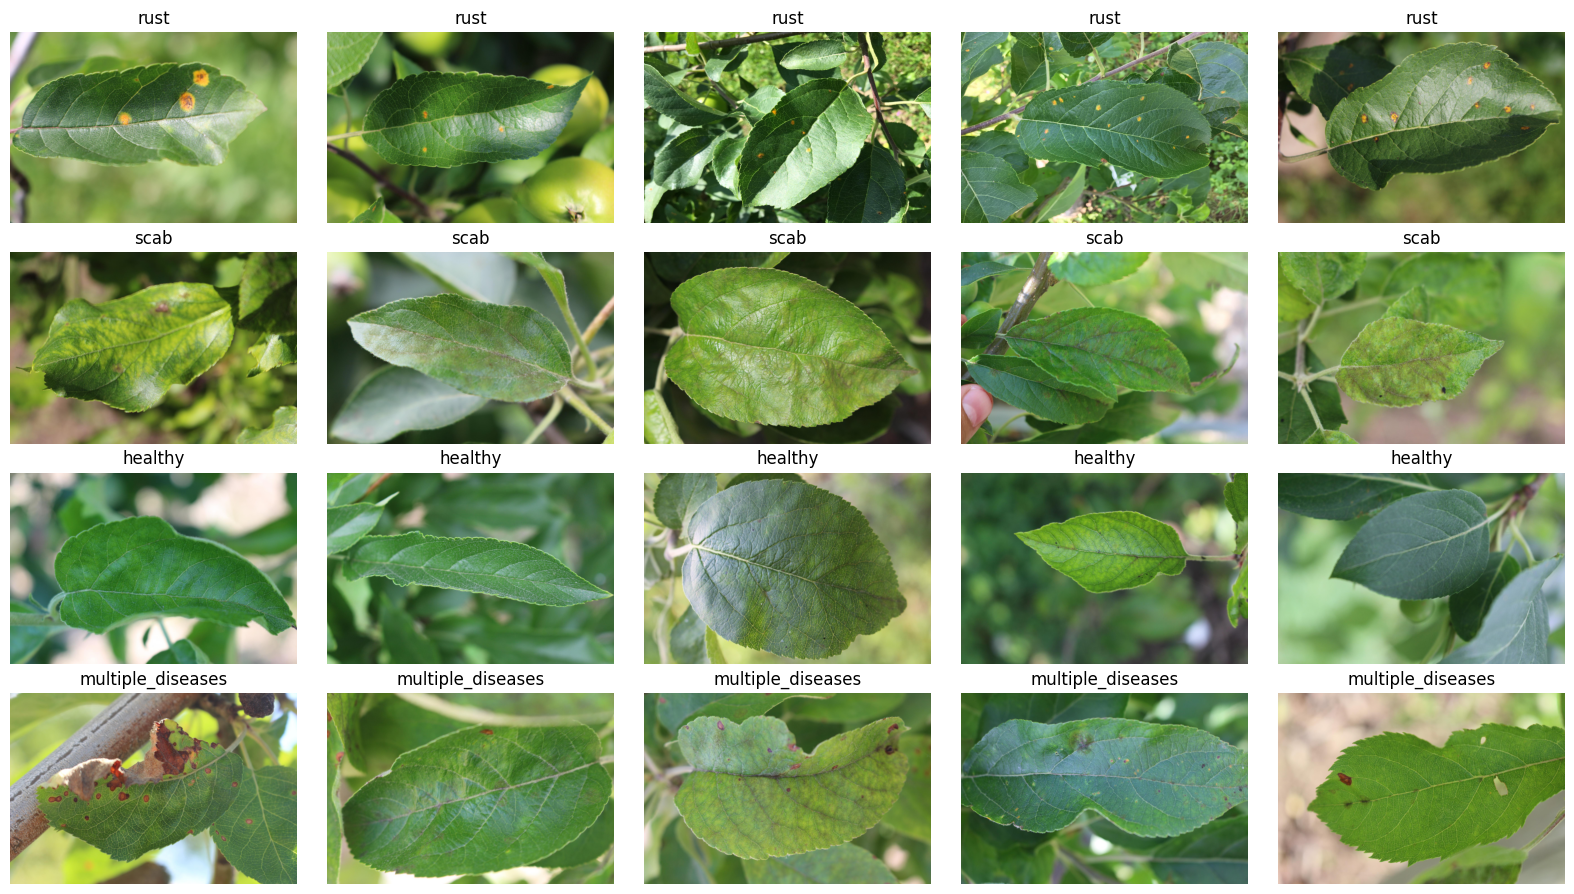

In [16]:
# Initialize subplots with number of labels rows and 5 columns
fig, axes = plt.subplots(nrows=len(tmp.index), ncols=5, figsize=(16, 9))

# Loop through selected images and display in the respective rows
labels = tmp.index
for i in range(len(labels)*5):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(data[labels[row]][col])
    axes[row, col].set_title(labels[row])
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [17]:
# Cleaning
del get_images_to_plot, get_image_label, img_path, img
del data, fig, axes, labels, row, col

# 5 Data preprocessing <a class="anchor" id="chapter_5"></a>

In [18]:
# Global configuration
BATCH_SIZE = 32
NUM_CLASSES = 4
NUM_EPOCHS = 25
IMAGE_HEIGHT, IMAGE_WIDTH = 224, 224

## 5.1 Upsampling <a class="anchor" id="chapter_5_1"></a>

This section aims to balance the class distribution in the training dataset by upsampling the minority classes.

In [19]:
# Get class distribution
class_counts = train_data.iloc[:, 1:].sum()

# Get maximum count of the majority class
max_count = class_counts.max()

# Upsample the minority classes to the max_count records
balanced_data = []
for class_name in class_counts.index:
    class_data = train_data[train_data[class_name] == 1]
    upsampled_data = class_data.sample(max_count
                                         , replace = True
                                         , random_state = 0)
    balanced_data.append(upsampled_data)

# Get final balanced dataframe
train_data_balanced = pd.concat(balanced_data, axis=0, ignore_index=True)
train_data_balanced.iloc[:, 1:].sum()

healthy              622
multiple_diseases    622
rust                 622
scab                 622
dtype: int64

## 5.2 Data augmentation <a class="anchor" id="chapter_5_2"></a>

Data augmentation in our task of image classification is crucial for two main reasons:

1. Increased Diversity: augmenting the data with various transformations provides a wider range of image variations, helping the model generalize better to unseen data.
2. Preventing Overfitting: it acts as a regularizer, reducing overfitting risk by exposing the model to diverse training instances.

In [20]:
def get_augmented_image(image):
    """
    Return augmented image.
    
    Args:
        image: image tensor
    Returns:
        image
    """
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, max_delta=0.1)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    
    return image

## 5.3 Train-test split <a class="anchor" id="chapter_5_3"></a>

In [21]:
# Get image paths and labels
image_paths = image_dir + train_data_balanced['image_id'] + '.jpg'
image_paths = image_paths.values
labels = train_data_balanced.loc[:, 'healthy':]

# Split into train and test sets fo training accuracy
X_train, X_test, y_train, y_test = train_test_split(image_paths
                                                    , labels
                                                    , test_size = 0.25
                                                    , shuffle = True
                                                    , random_state = 43)

In [22]:
del image_paths, labels

## 5.4 Parallel preprocessing <a class="anchor" id="chapter_5_4"></a>

We're going to incorporate Tensorflow parallel processing functions to use optimal number of CPU cores provided in this notebook.

In [23]:
def get_decoded_image(image_path, label = None):
    """
    Load and preprocess images using TensorFlow I/O
    and Image Generator transformation.
    
    Args:
        image_path: path to JPEG image
    Returns:
        image or tuple: decoded image or (image, label)
    """
    image = tf.io.read_file(image_path)
    # Set 3 channels, RGB
    image = tf.image.decode_image(image, channels=3)
    image.set_shape([None, None, 3])
    # Set size to convert to compatible with models input
    image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
    image = tf.cast(image, tf.float32) / 255.0
    image = get_augmented_image(image)
    
    return image if label is None else (image, label)
    

def get_prefetched_data(data):
    """
    Create a TensorFlow dataset from image paths.
    Execution in parallel.
    Load, preprocess images and batch the data.
    Prefetch batches to improve training performance.
    
    Args:
        data: ndarray of image paths + labels (opt)
    Returns:
        tf.data.Dataset: preprocessed and preloaded TensorFlow dataset for keras NN
    """
    # Autotune the degree of parallelism during training
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    
    # Create dataset from image paths
    dataset = tf.data.Dataset.from_tensor_slices(data)
    
    # Apply parallel processing to load and preprocess images
    dataset = dataset.map(get_decoded_image, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [24]:
# Get prefetched tf.data.DataSet for subsequent models
train_dataset = get_prefetched_data((X_train, y_train))
test_dataset = get_prefetched_data((X_test, y_test))

# 6. Model architectures <a class="anchor" id="chapter_6"></a>

ResNet, VGG-Net, and InceptionNet are selected due to their balanced combination of accuracy, computational efficiency, and ease of implementation. ResNet's strength lies in its ability to train deep networks effectively, making it ideal for incorporating additional dense layers. VGG-Net offers high training speed, crucial for working within notebook constraints. InceptionNet's multi-scale feature capturing capability is valuable for detecting various plant pathologies across different parts of an image.

In [42]:
def get_model(Model):
    """
    Return Model architecture.
    
    Args:
        obj: model class
    Returns:
        obj: model architecture
    """
    model = Model(weights='imagenet'
                     , include_top=False
                     , input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
    
    return model

def get_model_resnet():
    return get_model(ResNet50)

def get_model_vggnet():
    return get_model(VGG16)

def get_model_inceptionnet():
    return get_model(InceptionV3)

# 7. Model results <a class="anchor" id="chapter_7"></a>

In [34]:
def get_compiled_model(func):
    """
    Return model to be trained with a multi-GPU strategy.
    Allows data parallelism by copying all of the model's variables
    to each processor.
    
    Args:
        func: function to get model architecture
    Returns:
        compiled_model: tensorflow model
    """
    # Check if GPU is available
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        # Create a MirroredStrategy.
        strategy = tf.distribute.MirroredStrategy()

        print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
    else:
        strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
        print('No GPU available, falling back to CPU.')

    with strategy.scope():
        compiled_model = func()
        # Add custom classification layers for our task
        compiled_model = Sequential([
            compiled_model
            , layers.GlobalAveragePooling2D()
            # Add dense layers with 128 and 64 units 
            , layers.Dense(128, activation="relu")
            , layers.Dense(64, activation="relu")
            # Add regularization with dropout rate 30%
            , layers.Dropout(0.3)
            , layers.Dense(NUM_CLASSES, activation='softmax')
        ])
        compiled_model.compile(optimizer = 'adam'
                              , loss = 'categorical_crossentropy'
                              , metrics = ['categorical_accuracy'])

    return compiled_model

In [31]:
def plot_model_scores(scores, model_name):
    """
    Plot train and test accuracy scores of a model by epoch
    """
    train_scores, test_scores = scores
    epochs = range(1, len(train_scores) + 1)

    # Plot train and test scores
    plt.figure(figsize=(16, 9))
    plt.plot(epochs, train_scores, label='Train score')
    plt.plot(epochs, test_scores, label='Test score')
    plt.title('Train and test accuracy scores of the {}'.format(model_name))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    
def get_model_results(model_name, model):
    """
    Return tuple of runtime, train and test scores.
    Compile, fit and save model along the way.
    
    Args:
        model: fitted model
    Returns:
        (runtime, (train_scores, test_scores) )
    """
    model = get_compiled_model(model)
    
    st = time.time()
    model.fit(train_dataset, epochs = NUM_EPOCHS, validation_data=test_dataset)
    runtime = time.time() - st
    
    model.save('{}.h5'.format(model_name))
    
    train_scores = model.history.history['categorical_accuracy']
    test_scores = model.history.history['val_categorical_accuracy']
    
    tf.keras.backend.clear_session()
    
    return (runtime, (train_scores, test_scores))

## 7.1 ResNet <a class="anchor" id="chapter_7_1"></a>

In the initial 16 epochs the model faced challenges in classifying pathologies, achieving less than 50% test categorical accuracy. This struggle may have stemmed from the network memorizing similar pathologies in the images, resulting in low performance on unseen data. However, the introduction of Dropout regularization proved beneficial, as evident from the 17th epoch onward, boosting test scores from 50% to 70% and beyond. Despite this improvement leading to a 86% test categorical accuracy, overfitting remains a concern, indicated by high train scores at 97%. Increasing the dropout rate might help in preventing such problem.

In [35]:
# Get train and test scores of every epoch
runtime_resnet, scores_resnet = get_model_results('model_resnet'
                                                  ,get_model_resnet)

Number of devices: 1
Epoch 1/25
59/59 [==============================] - 64s 433ms/step - loss: 1.0811 - categorical_accuracy: 0.5707 - val_loss: 7.1066 - val_categorical_accuracy: 0.2685
Epoch 2/25
59/59 [==============================] - 26s 448ms/step - loss: 0.7882 - categorical_accuracy: 0.6967 - val_loss: 29.0691 - val_categorical_accuracy: 0.2669
Epoch 3/25
59/59 [==============================] - 30s 512ms/step - loss: 0.6317 - categorical_accuracy: 0.7680 - val_loss: 4.3454 - val_categorical_accuracy: 0.2106
Epoch 4/25
59/59 [==============================] - 26s 438ms/step - loss: 0.5253 - categorical_accuracy: 0.8237 - val_loss: 1.7839 - val_categorical_accuracy: 0.2106
Epoch 5/25
59/59 [==============================] - 27s 459ms/step - loss: 0.4481 - categorical_accuracy: 0.8376 - val_loss: 1.5602 - val_categorical_accuracy: 0.2106
Epoch 6/25
59/59 [==============================] - 27s 452ms/step - loss: 0.3809 - categorical_accuracy: 0.8655 - val_loss: 1.5260 - val_categ

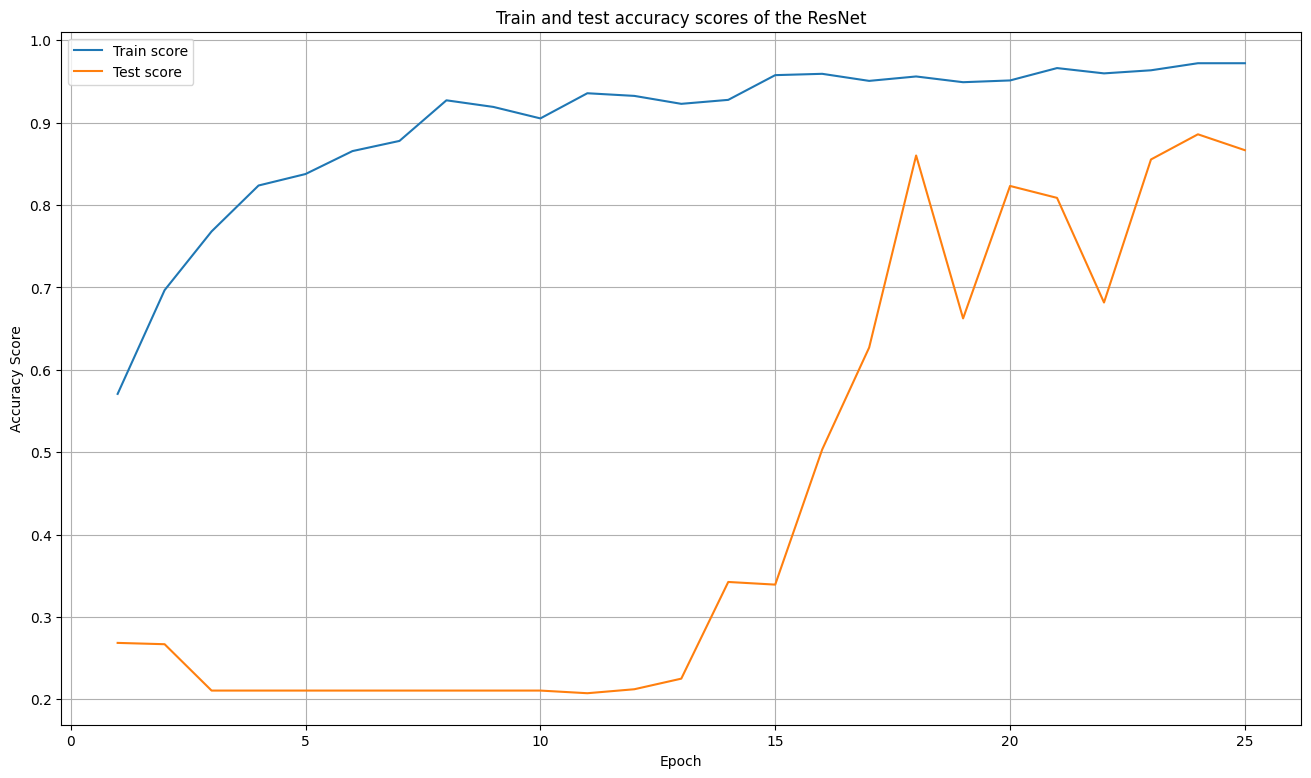

In [36]:
# Plot scores
plot_model_scores(scores_resnet, 'ResNet')

## 7.2 VGG-Net <a class="anchor" id="chapter_7_2"></a>

The performance of VGG-Net was unexpectedly poor throughout all epochs, barely surpassing 30% categorical accuracy. Surprisingly, it performed as poorly as a model predicting everything with one label, even with our improved and balanced dataset. VGG's simplicity, which usually speeds up training, seemed to hinder its ability to learn specific pathology features in the images. To improve its performance, it's necessary to either increase the model's depth or consider using a different set of pretrained weights.

In [39]:
# Get train and test scores of every epoch
runtime_vggnet, scores_vggnet = get_model_results('model_vggnet'
                                                  ,get_model_vggnet)

Number of devices: 1
Epoch 1/25
59/59 [==============================] - 33s 459ms/step - loss: 7236.2539 - categorical_accuracy: 0.2444 - val_loss: 1.3892 - val_categorical_accuracy: 0.2685
Epoch 2/25
59/59 [==============================] - 26s 439ms/step - loss: 20746370.0000 - categorical_accuracy: 0.2524 - val_loss: 1.3925 - val_categorical_accuracy: 0.2106
Epoch 3/25
59/59 [==============================] - 25s 426ms/step - loss: 10084940800.0000 - categorical_accuracy: 0.2471 - val_loss: 21.1251 - val_categorical_accuracy: 0.2685
Epoch 4/25
59/59 [==============================] - 26s 442ms/step - loss: 90346.3672 - categorical_accuracy: 0.2680 - val_loss: 42.5161 - val_categorical_accuracy: 0.2685
Epoch 5/25
59/59 [==============================] - 26s 447ms/step - loss: 73.8505 - categorical_accuracy: 0.2379 - val_loss: 27.5719 - val_categorical_accuracy: 0.2685
Epoch 6/25
59/59 [==============================] - 26s 439ms/step - loss: 21.5761 - categorical_accuracy: 0.2444 - 

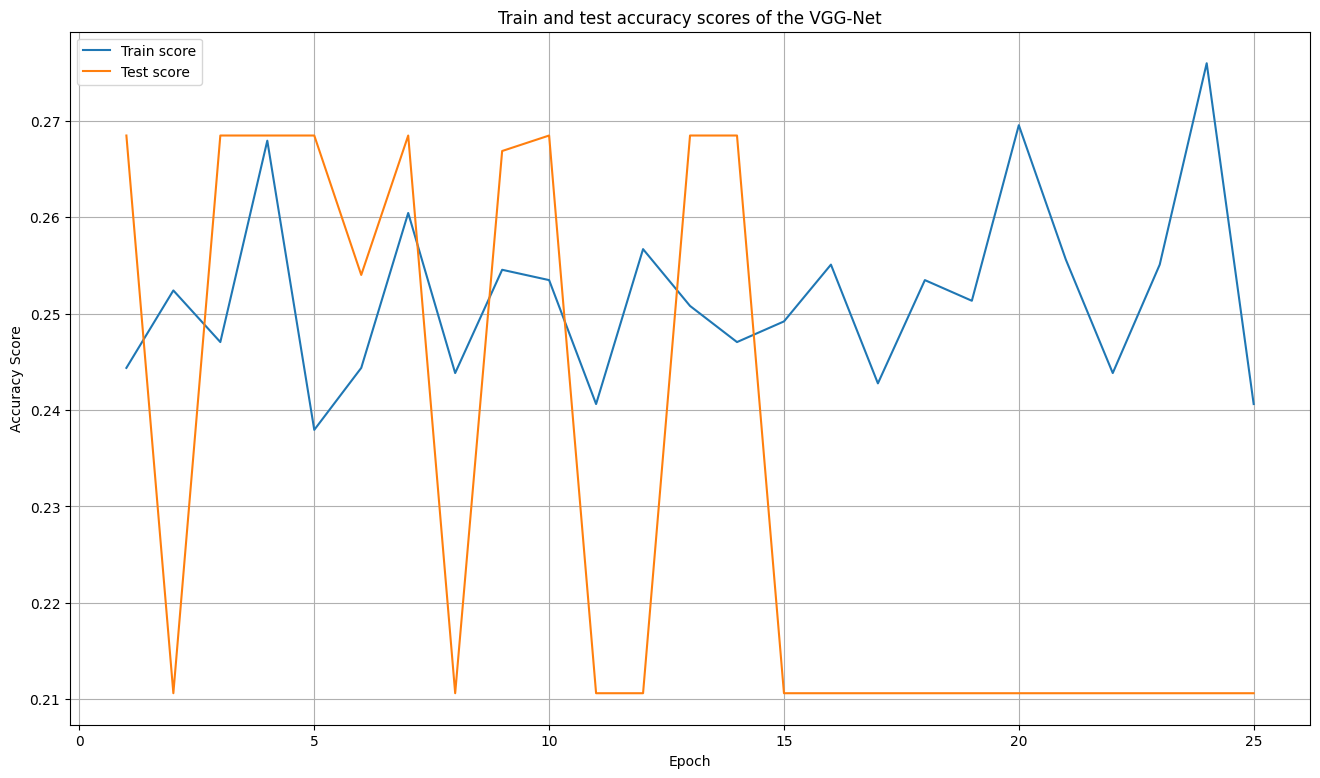

In [40]:
# Plot scores
plot_model_scores(scores_vggnet, 'VGG-Net')

## 7.3 InceptionNet <a class="anchor" id="chapter_7_3"></a>

InceptionNet showed remarkable progress, reaching an impressive 91% categorical accuracy. While it hit 90% within 10 epochs, the test scores then fluctuated until the very end, suggesting possible stability with more training. Adjusting the learning rate and expanding layer width or depth could also reduce bouncing and enhance the overall score.

In [43]:
# Get train and test scores of every epoch
runtime_inceptionnet, scores_inceptionnet = get_model_results('model_inceptionnet'
                                                  ,get_model_inceptionnet)

Number of devices: 1
87910968/87910968 [==============================] - 4s 0us/step
Epoch 1/25
59/59 [==============================] - 73s 492ms/step - loss: 0.9187 - categorical_accuracy: 0.6399 - val_loss: 59.1307 - val_categorical_accuracy: 0.3408
Epoch 2/25
59/59 [==============================] - 27s 454ms/step - loss: 0.7711 - categorical_accuracy: 0.7128 - val_loss: 14.2826 - val_categorical_accuracy: 0.4453
Epoch 3/25
59/59 [==============================] - 27s 463ms/step - loss: 0.5565 - categorical_accuracy: 0.7990 - val_loss: 1.0632 - val_categorical_accuracy: 0.6045
Epoch 4/25
59/59 [==============================] - 26s 441ms/step - loss: 0.4238 - categorical_accuracy: 0.8548 - val_loss: 2.3262 - val_categorical_accuracy: 0.6141
Epoch 5/25
59/59 [==============================] - 30s 513ms/step - loss: 0.3382 - categorical_accuracy: 0.8821 - val_loss: 1.5173 - val_categorical_accuracy: 0.7090
Epoch 6/25
59/59 [==============================] - 31s 530ms/step - loss: 0.

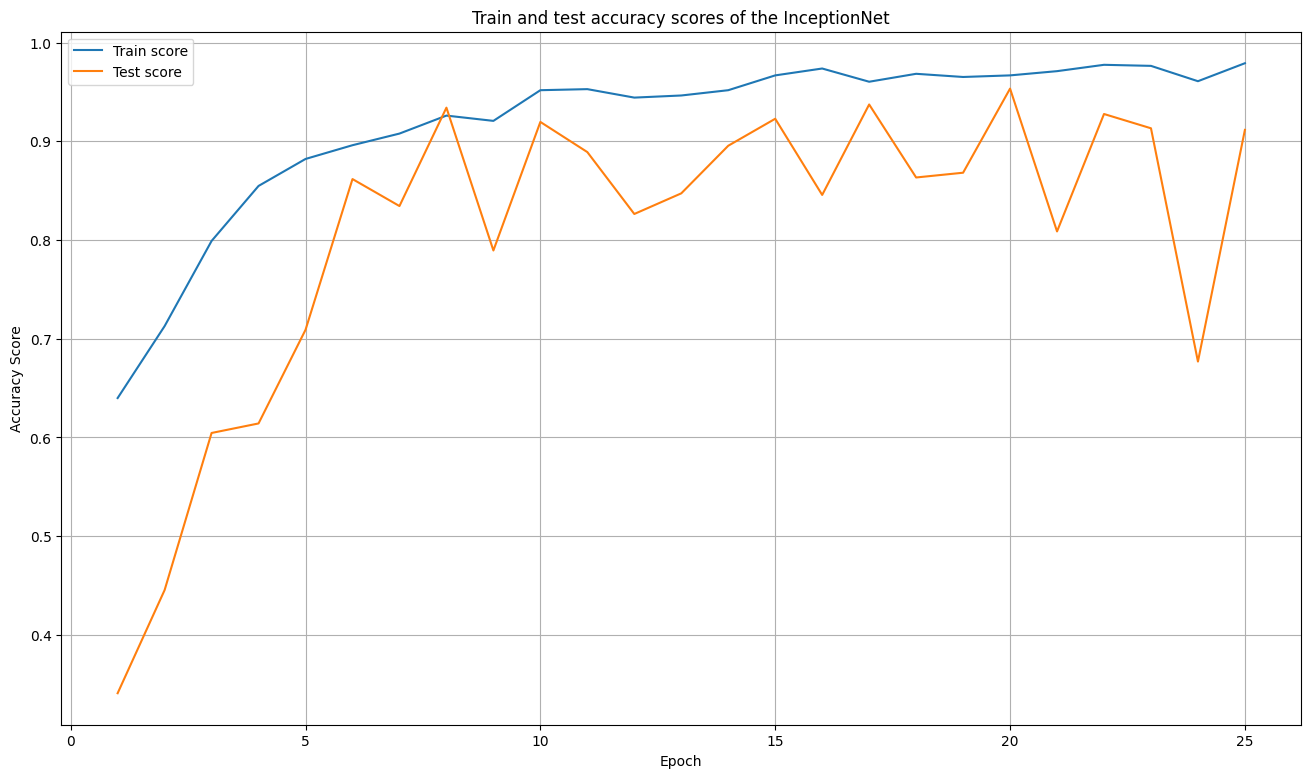

In [44]:
# Plot scores
plot_model_scores(scores_inceptionnet, 'InceptionNet')

## 7.4 Table results comparison <a class="anchor" id="chapter_7_4"></a>

In [46]:
# Print table results
results = [('ResNet', runtime_resnet, scores_resnet)
          ,('VGG-Net', runtime_vggnet, scores_vggnet)
          ,('InceptionNet', runtime_inceptionnet, scores_inceptionnet)]
table = []
for i in range(len(results)):
    tmp = {
            'model': results[i][0]
            , 'runtime (sec)': results[i][1]
            , 'train_score (cat. accuracy)': results[i][2][0][-1]
            , 'test_score (cat. accuracy)': results[i][2][1][-1]
        }
    table.append(tmp)


pd.DataFrame(table).sort_values(by = ['test_score (cat. accuracy)'
                                      ,'runtime (sec)']
                                , ascending = [False
                                               , True]).reset_index(drop = True)

,model,runtime (sec),train_score (cat. accuracy),test_score (cat. accuracy)
0,InceptionNet,724.932137,0.979100,0.911576
1,ResNet,752.768092,0.972133,0.866560
2,VGG-Net,658.876898,0.240622,0.210611


In [ ]:
# Cleaning
del results, tmp, table
del get_model_results, plot_model_scores, get_compiled_model

# 8. Submission results <a class="anchor" id="chapter_8"></a>

### Public score: 0.90217

In [48]:
# Load top model
model = load_model('model_inceptionnet.h5')

In [52]:
# Create prefethed dataset of images to classify
submit_data = image_dir + sample_data['image_id'] + '.jpg'
submit_data = submit_data.values

submit_dataset = get_prefetched_data((submit_data))

In [53]:
# Get results
results = model.predict(submit_dataset)

57/57 [==============================] - 25s 410ms/step


In [56]:
# Merge results with sample submission
sample_data.loc[:, 'healthy':] = results

In [58]:
# Make submission
sample_data.to_csv('submission.csv', index=False)

In [ ]:
# Cleaning
del submit_data, submit_dataset, sample_data
del get_decoded_image, get_prefetched_data

# 9. Conclusion <a class="anchor" id="chapter_9"></a>

In this study we compared three pretrained convolutional neural network architectures:
1. ResNet
2. VGG-Net
3. InceptionNet

aiming to achieve high accuracy in classifying plant pathologies from images.

The initial challenges faced by the models, particularly in the case of ResNet, were mitigated with the introduction of Dropout regularization, leading to a significant improvement from 50% to 70% test categorical accuracy. However, despite reaching an 86% test accuracy, overfitting remained a concern.

VGG-Net, surprisingly, exhibited poor performance throughout all epochs, struggling to surpass 30% categorical accuracy. Even with an improved dataset, its simplicity appeared to hinder its ability to learn specific pathology features. To enhance its performance, adjustments in model depth or pretrained weights are necessary.

In contrast, InceptionNet demonstrated exceptional progress, achieving an impressive 91% categorical accuracy. While encountering fluctuations in test scores after reaching 90% within 10 epochs, the model showcased promise for stability with further training. Fine-tuning parameters, such as learning rate, and expanding layer width or depth, could further enhance the model's performance.

# 10. References <a class="anchor" id="chapter_10"></a>

* Thapa, Ranjita; Zhang, Kai; Snavely, Noah; Belongie, Serge; Khan, Awais. The Plant Pathology Challenge 2020 data set to classify foliar disease of apples. Applications in Plant Sciences, 8 (9), 2020.<br/>
https://bsapubs.onlinelibrary.wiley.com/doi/10.1002/aps3.11390
* Karen Simonyan and Andrew Zisserman. (2014). Very Deep Convolutional Networks for Large-Scale Image Recognition<br/>
https://arxiv.org/abs/1409.1556
* Kaiming He, Xiangyu Zhang, Shaoqing Ren, (2015). Jian Sun. Deep Residual Learning for Image Recognition<br/>
https://arxiv.org/abs/1512.03385
* Christian Szegedy, Wei Liu, Yangqing Jia, Pierre Sermanet, Scott Reed, Dragomir Anguelov, Dumitru Erhan, Vincent Vanhoucke, Andrew Rabinovich. (2014). Going Deeper with Convolutions<br/>
https://arxiv.org/abs/1409.4842
* Histopathologic Cancer Detection: Exploring architectural variations and hyperparameter impact on CNN<br/>
https://www.kaggle.com/code/jaymanvirk/model-designs-impact-on-cnn
* Better performance with the tf.data API<br/>
https://www.tensorflow.org/guide/data_performance
* Distributed training with Tensorflow<br/>
https://www.tensorflow.org/guide/distributed_training
* Tensorflow GPU<br/>
https://www.tensorflow.org/guide/gpu